In [1]:
# import libraries
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchinfo import summary
from contextlib import redirect_stdout

# from lib.cnnae_fully_convolutional import createLevel3FullyConvNet as createNet
from lib.cnnae_fully_convolutional import createLevel3FullyConvDropoutNet as createNet
# from lib.cnnae_fc_latent_layer import createLevel3FullyConnectedNet as createNet

from lib.evaluate import evaluate_total_predictions_set, display_mazes

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load data
path_to_data = "./data/reference/"

X_normal = np.load(f"{path_to_data}X.dat.npy")
X_small = np.load(f"{path_to_data}X.dat_smol.npy")
X_test = np.load(f"{path_to_data}X.dat_test.npy")
Y_normal = np.load(f"{path_to_data}Y.dat.npy")
Y_small = np.load(f"{path_to_data}Y.dat_smol.npy")
Y_test = np.load(f"{path_to_data}Y.dat_test.npy")

In [4]:
# Add a channel dimension (for grayscale 1-channel data)
X_normal = np.expand_dims(X_normal, axis=1)  # Shape: (63052, 1, 7, 7)
X_small = np.expand_dims(X_small, axis=1)
X_test = np.expand_dims(X_test, axis=1)
Y_normal = np.expand_dims(Y_normal, axis=1)
Y_small = np.expand_dims(Y_small, axis=1)
Y_test = np.expand_dims(Y_test, axis=1)

In [11]:
Y_test.shape

(31455, 1, 7, 7)

In [7]:
# transform data
X_normal_tensor = torch.tensor(X_normal, dtype=torch.float32, device=device)
X_small_tensor = torch.tensor(X_small, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
Y_normal_tensor = torch.tensor(Y_normal, dtype=torch.float32, device=device)
Y_small_tensor = torch.tensor(Y_small, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32, device=device)

In [8]:
X_test_tensor.shape

torch.Size([31455, 1, 7, 7])

In [8]:
# create dataset
normal_data = TensorDataset(X_normal_tensor, Y_normal_tensor)
small_data = TensorDataset(X_small_tensor, Y_small_tensor)
test_data = TensorDataset(X_test_tensor, Y_test_tensor)

batchsize    = 512
train_loader = DataLoader(normal_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [9]:
# channel_configuration = (15, 84, 167)
# channel_configuration = (24, 15, 35)
# channel_configuration = (10, 10, 10)
# channel_configuration = (24, 10, 10)
# channel_configuration = (24, 10, 24)
# channel_configuration = (24, 24, 10)
# channel_configuration = (10, 24, 24)
# channel_configuration = (15, 24, 33) # 99.6498
# channel_configuration = (33, 24, 15) # 99.4907
# channel_configuration = (15, 18, 24) # 99.2997 @200
# channel_configuration = (15, 18, 24) # 99.2519 @300
# channel_configuration = (15, 21, 27) # 99.2838
# channel_configuration = (15, 19, 25) # 98.7745 Last has dropout
# channel_configuration = (15, 19, 25) # 99.2838 Last has no dropout
# channel_configuration = (15, 24, 33) # 99.6260 Dropout 0.2
# channel_configuration = (15, 24, 33) # 99.5225 Dropout 0.1
channel_configuration = (15, 24, 99)
net, criterion, optimizer = createNet(channels=channel_configuration)


X, y = next(iter(train_loader))


net.to(device)


# Get the network's prediction

y_hat = net(X)

In [10]:
def trainNet(num_epochs = 20):
    net, criterion, optimizer = createNet(channels=channel_configuration)

    net.to(device)

    # initialize losses
    train_loss = torch.zeros(num_epochs)
    test_loss = torch.zeros(num_epochs)

    for epoch in range(num_epochs):

        net.train()  # switch to train mode
        batch_loss = []

        for X,y in train_loader:

            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)
            loss = criterion(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

        train_loss[epoch] = np.mean(batch_loss)

        net.eval()  # switch to test mode
        batch_loss = []

        for X, y in test_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            with torch.no_grad():
                y_hat = net(X)
                loss = criterion(y_hat, y)

            # loss and accuracy from this batch
            batch_loss.append(loss.item())

        test_loss[epoch] = np.mean(batch_loss)

        print(f"Finished epoch: {epoch+1} with loss: {train_loss[epoch]:.6f}")

    return train_loss, test_loss, net

In [11]:
num_epochs = 100
train_loss, test_loss, net = trainNet(num_epochs)

Finished epoch: 1 with loss: 1.189351
Finished epoch: 2 with loss: 0.685787
Finished epoch: 3 with loss: 0.573000
Finished epoch: 4 with loss: 0.505922
Finished epoch: 5 with loss: 0.456527
Finished epoch: 6 with loss: 0.418991
Finished epoch: 7 with loss: 0.390245
Finished epoch: 8 with loss: 0.367689
Finished epoch: 9 with loss: 0.348735
Finished epoch: 10 with loss: 0.331658
Finished epoch: 11 with loss: 0.315019
Finished epoch: 12 with loss: 0.300353
Finished epoch: 13 with loss: 0.285131
Finished epoch: 14 with loss: 0.271770
Finished epoch: 15 with loss: 0.258858
Finished epoch: 16 with loss: 0.246028
Finished epoch: 17 with loss: 0.234769
Finished epoch: 18 with loss: 0.224057
Finished epoch: 19 with loss: 0.214174
Finished epoch: 20 with loss: 0.205292
Finished epoch: 21 with loss: 0.196808
Finished epoch: 22 with loss: 0.188300
Finished epoch: 23 with loss: 0.180375
Finished epoch: 24 with loss: 0.173339
Finished epoch: 25 with loss: 0.167309
Finished epoch: 26 with loss: 0.16

In [12]:
os.makedirs("./archive/temp/", exist_ok=True)
torch.save(net.state_dict(), f"./archive/temp/net.pt")

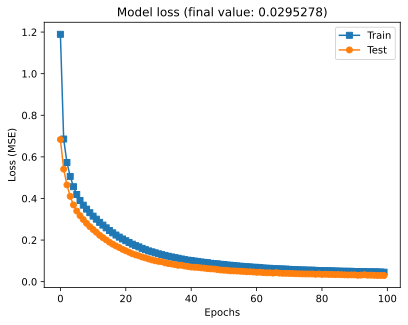

In [13]:
plt.plot(train_loss, "s-", label="Train")
plt.plot(test_loss, "o-", label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model loss (final value: %g)" % test_loss[-1])
plt.legend()

plt.savefig("./archive/temp/loss.png", bbox_inches="tight")
plt.show()

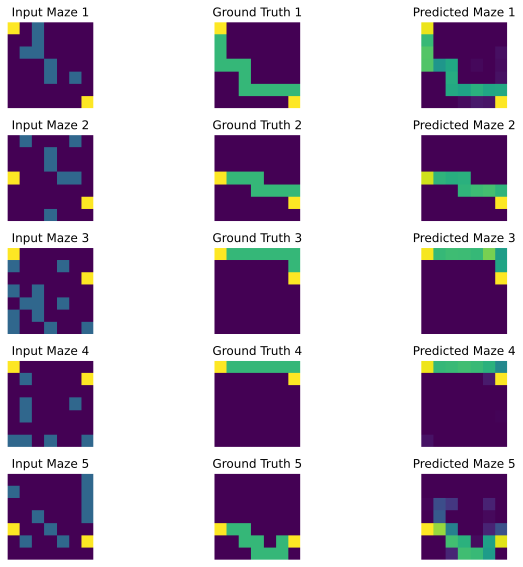

In [14]:
# Get a batch of data
X, y = next(iter(train_loader))

X = X.to(device)
y = y.to(device)

# Get the network's prediction
y_hat = net(X)

# Select two samples to display
num_samples = 5

# Create a matplotlib figure (3 columns: Input, Ground Truth, Prediction)
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 8))

for i in range(num_samples):
    # Original data (input)
    axes[i, 0].imshow(X[i, 0].detach().cpu().numpy(), cmap="viridis")
    axes[i, 0].set_title(f"Input Maze {i+1}")
    axes[i, 0].axis("off")

    # Ground truth label
    axes[i, 1].imshow(y[i, 0].detach().cpu().numpy(), cmap="viridis")
    axes[i, 1].set_title(f"Ground Truth {i+1}")
    axes[i, 1].axis("off")

    # Predicted label (output from the network)
    axes[i, 2].imshow(y_hat[i, 0].detach().cpu().numpy(), cmap="viridis")
    axes[i, 2].set_title(f"Predicted Maze {i+1}")
    axes[i, 2].axis("off")

# Adjust layout
plt.tight_layout()
plt.savefig("./archive/temp/input_truth_prediction.png", bbox_inches="tight")
plt.show()

In [15]:
with open("./archive/temp/meta.txt", "w") as file:
    file.write(f"batch_size: {batchsize}\n")
    file.write(f"num_epochs: {num_epochs}\n")
    with redirect_stdout(file):
        print(summary(net, (batchsize, 1, 7, 7)))

In [16]:

import numpy as np
import torch
path_to_data = "./data/reference/"

Y_test = np.load(f"{path_to_data}Y.dat_smol.npy")
X_test = np.load(f"{path_to_data}X.dat_smol.npy")
# X_test = np.expand_dims(X_test, axis=1)
# Y_test = np.expand_dims(Y_test, axis=1)
X_test_tensor = torch.tensor(X_test[:, np.newaxis], dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test[:, np.newaxis], dtype=torch.float32)

In [17]:
X_test_tensor.shape

torch.Size([12566, 1, 7, 7])

In [18]:
net.to("cpu")
y_hat = net(X_test_tensor)

In [24]:
Y_test_tensor[0]

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 2., 2., 2., 3.],
         [3., 2., 2., 2., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]])

In [19]:
correct_percentage, preds, wrong_preds = evaluate_total_predictions_set(
    y_hat, Y_test_tensor
)


----------MODEL SUMMARY-----------
TOTAL SET SIZE:  12566
CORRECT GUESSES:  12488
TOTALING TO ACCURACY%:  99.37927741524749
------------------------------------




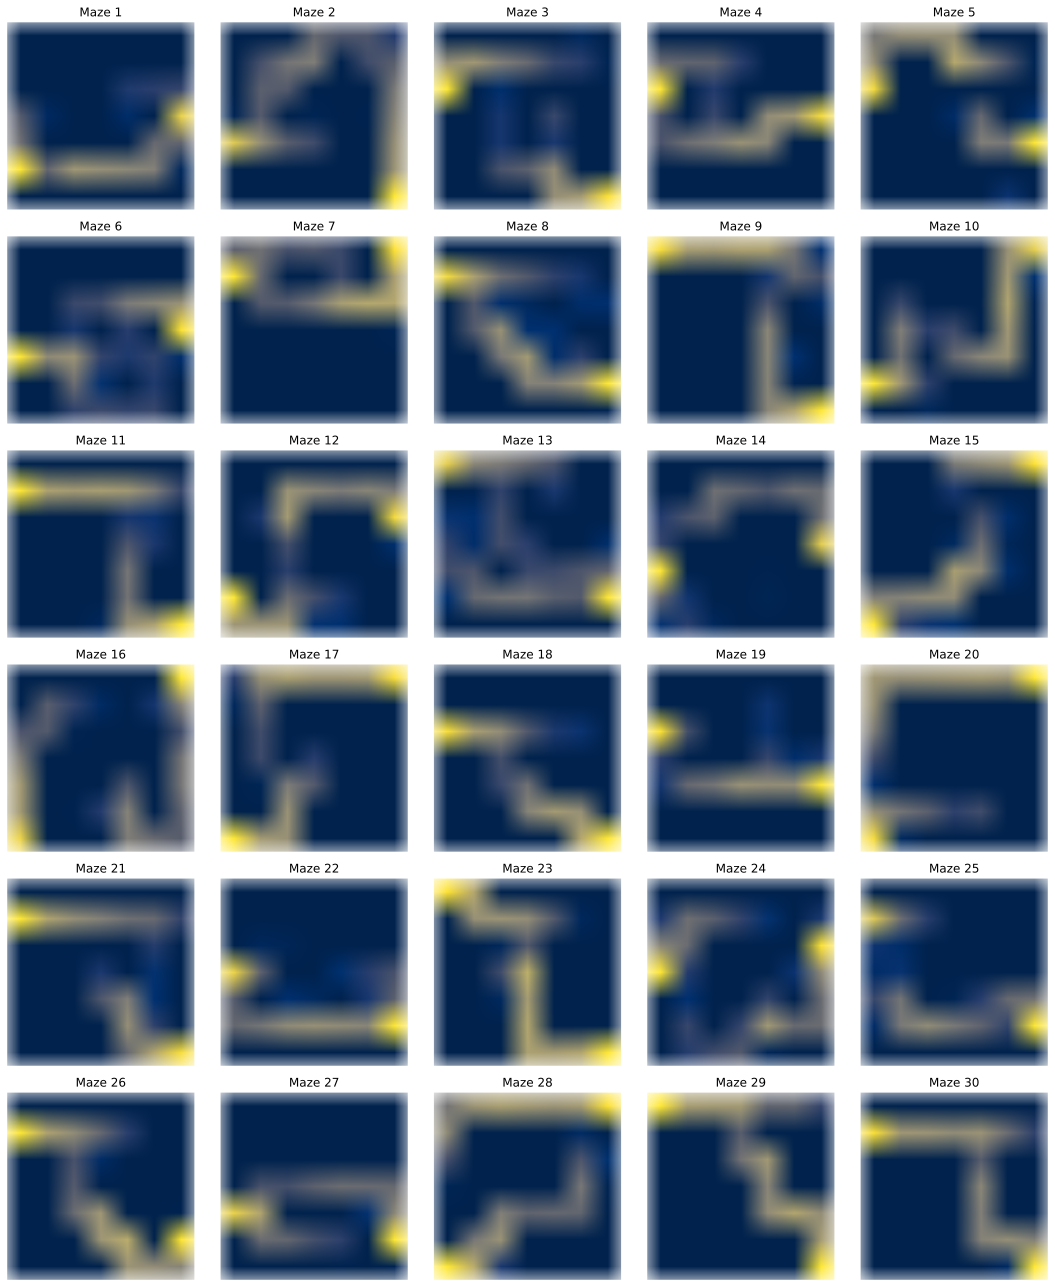

In [20]:
wrong_preds_unsqueezed = wrong_preds.unsqueeze(1)

if wrong_preds_unsqueezed.size(0) > 0:
    fig = display_mazes(wrong_preds_unsqueezed)
    fig.savefig(
        "./archive/temp/wrong_predictions.png",
        bbox_inches="tight",
    )
else:
    print("No wrong predictions!")

In [21]:
os.rename("./archive/temp", f"./archive/{net.__class__.__name__}_{correct_percentage:.4f}")